In [1]:
from typing import Callable
import numpy as np
import pandas as pd
from verma_net_radiation_sensitivity.verma_net_radiation_sensitivity import process_verma_net_radiation_table
import matplotlib.pyplot as plt

In [2]:
def repeat_rows(df: pd.DataFrame, n: int) -> pd.DataFrame:
    return pd.DataFrame(np.repeat(df.values, n, axis=0), columns=df.columns)

In [3]:
def perturbed_run(
        input_df: pd.DataFrame, 
        input_variable: str, 
        output_variable: str, 
        forward_process: Callable,
        n: int = 100, 
        perturbation_mean: float = 0,
        perturbation_std: float = None) -> pd.DataFrame:
    input_std = np.nanstd(input_df[input_variable])

    if perturbation_std is None:
        perturbation_std = input_std
    
    unperturbed_output_df = forward_process(input_df)
    unperturbed_output = unperturbed_output_df[output_variable]
    unperturbed_output = repeat_rows(unperturbed_output_df, n)[output_variable]
    input_perturbation = np.concatenate([np.random.normal(0, perturbation_std, n) for i in range(len(input_df))])
    perturbed_input_df = input_df.copy()
    perturbed_input_df = repeat_rows(perturbed_input_df, n)
    unperturbed_input = perturbed_input_df[input_variable]
    perturbed_input_df[input_variable] = perturbed_input_df[input_variable] + input_perturbation
    perturbed_input = perturbed_input_df[input_variable]
    perturbed_output_df = forward_process(perturbed_input_df)
    perturbed_output = perturbed_output_df[output_variable]
    output_perturbation = perturbed_output - unperturbed_output

    results_df = pd.DataFrame({
        f"{input_variable}_unperturbed": unperturbed_input,
        f"{input_variable}_perturbation": input_perturbation,
        f"{input_variable}_perturbed": perturbed_input,
        f"{output_variable}_unperturbed": unperturbed_output,
        f"{output_variable}_perturbation": output_perturbation,
        f"{output_variable}_perturbed": perturbed_output, 
    })

    return results_df

In [4]:
input_df = pd.read_csv("ha2_FLiES_outputs.csv")
input_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'tower', 'lat', 'lon', 'time_UTC',
       'date_UTC', 'time_solar', 'NDVI', 'NDVI-UQ', 'albedo', 'albedo-UQ',
       'BESSinst', 'ESI', 'ESIdaily', 'ESIdailyUncertainty', 'ETdaily',
       'ETdailyUncertainty', 'ETinstUncertainty', 'EmisWB', 'GPP', 'LST',
       'LST_err', 'MOD16inst', 'PET', 'PTJPLSMcanopy', 'PTJPLSMinst',
       'PTJPLSMinterception', 'PTJPLSMsoil', 'RH', 'Rg', 'Rn', 'SM',
       'STICcanopy', 'STICinst', 'Ta_C', 'WUE', 'elevation_m', 'radiance_2',
       'radiance_4', 'radiance_5', 'view_zenith', 'elevation_km', 'doy', 'AOT',
       'COT', 'vapor_gccm', 'ozone_cm', 'SZA', 'KG', 'Ra', 'UV', 'VIS', 'NIR',
       'VISdiff', 'NIRdiff', 'VISdir', 'NIRdir'],
      dtype='object')

input variable: LST
output variable: Rn


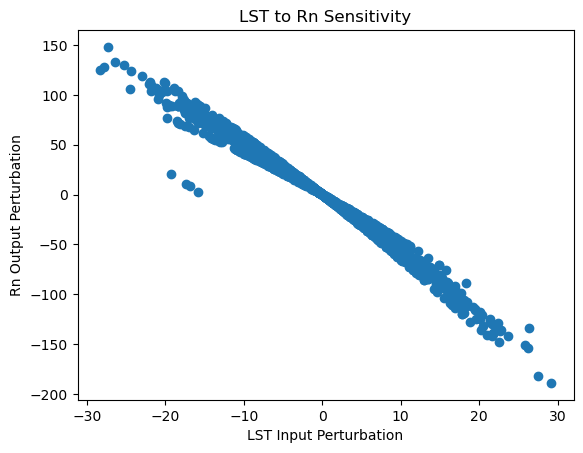

input variable: LST
output variable: SWout
no relationship between LST and SWout
input variable: LST
output variable: LWin
no relationship between LST and LWin
input variable: LST
output variable: LWout


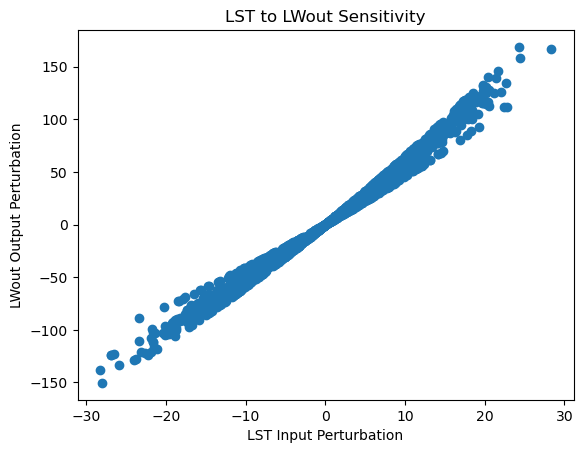

input variable: Rg
output variable: Rn


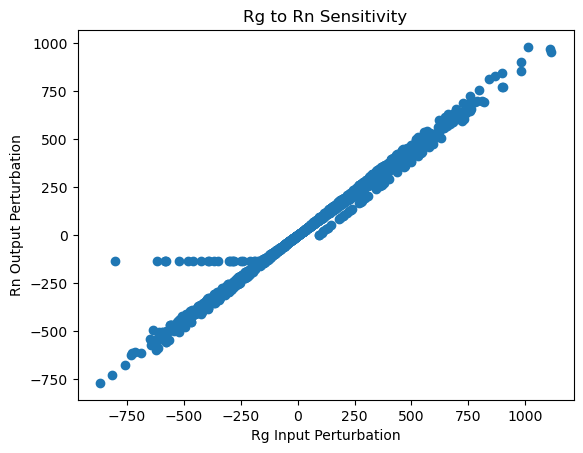

input variable: Rg
output variable: SWout


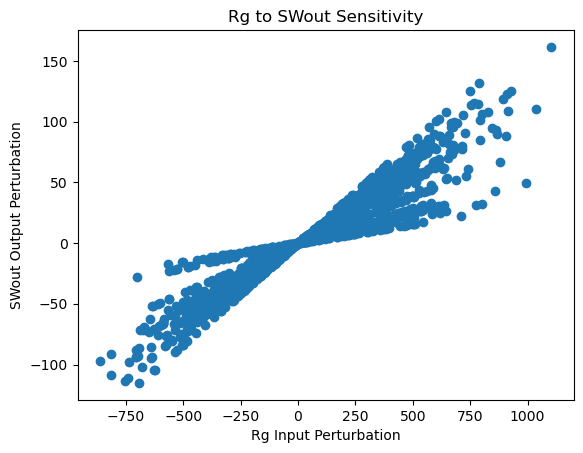

input variable: Rg
output variable: LWin
no relationship between Rg and LWin
input variable: Rg
output variable: LWout
no relationship between Rg and LWout
input variable: Ta_C
output variable: Rn


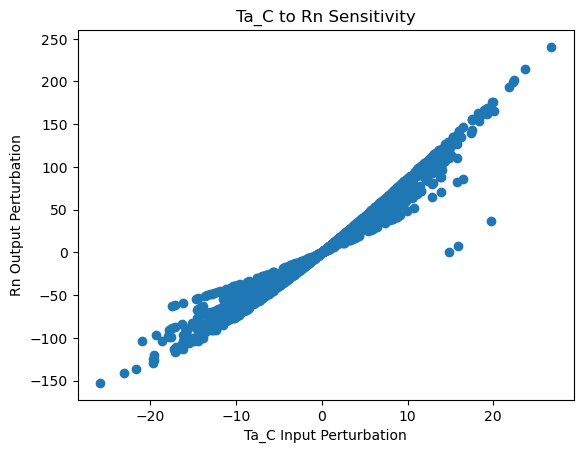

input variable: Ta_C
output variable: SWout
no relationship between Ta_C and SWout
input variable: Ta_C
output variable: LWin


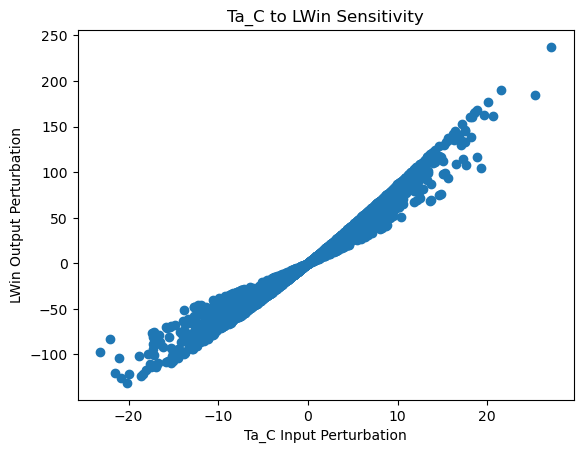

input variable: Ta_C
output variable: LWout
no relationship between Ta_C and LWout
input variable: RH
output variable: Rn


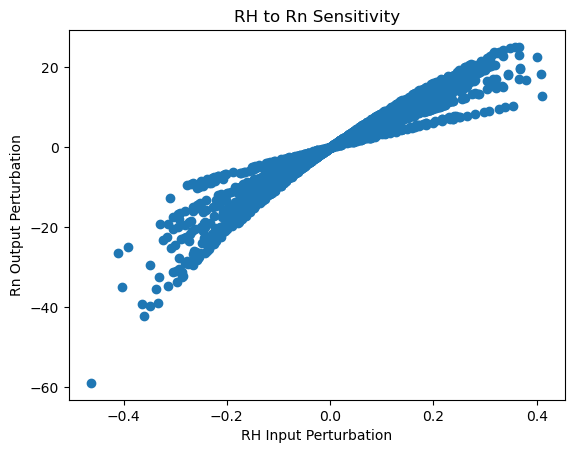

input variable: RH
output variable: SWout
no relationship between RH and SWout
input variable: RH
output variable: LWin


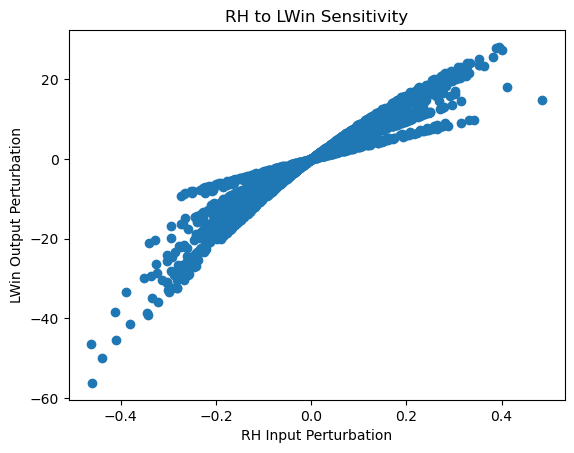

input variable: RH
output variable: LWout
no relationship between RH and LWout


In [5]:
forward_process = process_verma_net_radiation_table   
input_variables = ["LST", "Rg", "Ta_C", "RH"]
output_variables = ["Rn", "SWout", "LWin", "LWout"]

for input_variable in input_variables:
    for output_variable in output_variables:
        print(f"input variable: {input_variable}")
        print(f"output variable: {output_variable}")
        
        # run forward process with perturbation
        results = perturbed_run(input_df, input_variable, output_variable, forward_process)
        results = results[results[f"{output_variable}_perturbed"] != 0]
        results = results[results[f"{output_variable}_perturbation"] != 0]

        if len(results) == 0:
            print(f"no relationship between {input_variable} and {output_variable}")
            continue

        input_perturbation = results[f"{input_variable}_perturbation"]
        output_perturbation = results[f"{output_variable}_perturbation"]

        # create figure and axis objects
        fig, ax = plt.subplots()

        # create scatter plot
        ax.scatter(input_perturbation, output_perturbation)

        # set title and axis labels
        ax.set_title(f"{input_variable} to {output_variable} Sensitivity")
        ax.set_xlabel(f"{input_variable} Input Perturbation")
        ax.set_ylabel(f"{output_variable} Output Perturbation")

        # show plot
        plt.show()

        